In [2]:
import os
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
import pandas as pd

In [1]:
# store and sample experiences for training neural networks. It allows for efficient storage and retrieval of transitions
class ReplayBuffer:
    #Constructor Method
    def __init__(self, buffer_limit):
        self.buffer = deque(maxlen=buffer_limit)
    #adds a new transition (state, action, reward, next state, and done flag) to the buffer.
    def put(self, transition):
        self.buffer.append(transition)
    #randomly selects n transitions from the buffer
    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        #states, actions, rewards, next states, done
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask = 0.0 if done else 1.0
            done_mask_lst.append([done_mask])
        #tensor format for processing
        s_batch = torch.tensor(s_lst, dtype=torch.float)
        a_batch = torch.tensor(a_lst, dtype=torch.float)
        r_batch = torch.tensor(r_lst, dtype=torch.float)
        s_prime_batch = torch.tensor(s_prime_lst, dtype=torch.float)
        done_batch = torch.tensor(done_mask_lst, dtype=torch.float)


        return s_batch, a_batch, r_batch, s_prime_batch, done_batch
    #returns the current size of the buffer
    def size(self):
        return len(self.buffer)

In [3]:
#defines a neural network (3 layers)
#nn.Module (parent class)
class QNetwork(nn.Module):
    #Constructor Method
    def __init__(self, state_dim, action_dim, q_lr):
        #constructor of the parent class
        super(QNetwork, self).__init__()
        #Layers
        self.fc_1 = nn.Linear(state_dim, 64)
        self.fc_2 = nn.Linear(64, 32)
        self.fc_out =nn.Linear(32, action_dim) #output the Q-values

        self.lr = q_lr #learning rate

        self.optimizer = optim.Adam(self.parameters(), lr=self.lr)

    def forward(self, x):
        q = F.leaky_relu(self.fc_1(x))
        q = F.leaky_relu(self.fc_2(q))
        q = self.fc_out(q)
        return q

In [4]:
class DQNAgent:
    #constructor
    def __init__(self):
        self.state_dim     = 3    #state space dimensions : x-y coordinates of the pendulum's free end and its angular velocity
        self.action_dim    = 9    #9 actions : -2, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0
        self.lr            = 0.01 #learning rate
        self.gamma         = 0.98 #discount factor
        self.tau           = 0.01
        self.epsilon       = 1.0
        self.epsilon_decay = 0.98
        self.epsilon_min   = 0.001
        self.buffer_size   = 100000
        self.batch_size    = 200  #number of samples used in each training iteration.
        self.memory        = ReplayBuffer(self.buffer_size)

        self.Q        = QNetwork(self.state_dim, self.action_dim, self.lr) #main Q-network takes the state of the environment as input and outputs Q-values for all possible actions in that state
        self.Q_target = QNetwork(self.state_dim, self.action_dim, self.lr) #it to begin training with parameters that have already learned some useful representations of the environment
        self.Q_target.load_state_dict(self.Q.state_dict())  #extract the current parameters of the main Q-network into the target Q-network

    #selecting an action based on the current state
    def choose_action(self, state):
        random_number = np.random.rand()
        maxQ_action_count = 0 #flag indicating whether the action was selected based on the maximum Q-value
        #epsilon-greedy policy
        if self.epsilon < random_number:
            with torch.no_grad():
                action = float(torch.argmax(self.Q(state)).numpy())
                real_action = (action - 4) / 4 #scaling action between [-1,1]
                maxQ_action_count = 1
        else:
            action = np.random.choice([n for n in range(9)])
            real_action = (action - 4) / 2  # -2, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0

        return action, real_action, maxQ_action_count


    def calc_target(self, mini_batch):
        #current states, actions, rewards, next states, done
        s, a, r, s_prime, done = mini_batch
        with torch.no_grad(): #apply no grdiant
            q_target = self.Q_target(s_prime).max(1)[0].unsqueeze(1) # calculates the maximum Q-value for the next states using the target Q-network
            target = r + self.gamma * done * q_target #Bellman equation
        return target

    #training the DQN agent using experiences sampled from the replay buffer
    def train_agent(self):
        mini_batch = self.memory.sample(self.batch_size)
        s_batch, a_batch, r_batch, s_prime_batch, done_batch = mini_batch
        a_batch = a_batch.type(torch.int64) #casting actions ensures that they are compatible with tensor operations

        td_target = self.calc_target(mini_batch)

        #### Q train ####
        Q_a = self.Q(s_batch).gather(1, a_batch) # calculates the Q-values for the chosen actions using the main Q-network
        q_loss = F.smooth_l1_loss(Q_a, td_target)
        self.Q.optimizer.zero_grad()
        q_loss.mean().backward() #calculate gradients
        self.Q.optimizer.step()  #updates the Q-network parameters using the optimizer based on the computed gradients.
        #### Q train ####

        #### Q soft-update ####
        for param_target, param in zip(self.Q_target.parameters(), self.Q.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)


In [5]:
env = gym.make('Pendulum-v1')

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [7]:
cd pendulum_DQN/

/content/pendulum_DQN


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


EP:0, Avg_Score:-770.9, MaxQ_Action_Count:0, Epsilon:1.00000
EP:1, Avg_Score:-1119.1, MaxQ_Action_Count:5, Epsilon:0.98000
EP:2, Avg_Score:-864.8, MaxQ_Action_Count:8, Epsilon:0.96040
EP:3, Avg_Score:-765.8, MaxQ_Action_Count:9, Epsilon:0.94119
EP:4, Avg_Score:-1182.7, MaxQ_Action_Count:25, Epsilon:0.92237
Training started!
EP:5, Avg_Score:-967.7, MaxQ_Action_Count:21, Epsilon:0.90392
EP:6, Avg_Score:-986.6, MaxQ_Action_Count:22, Epsilon:0.88584
EP:7, Avg_Score:-1302.8, MaxQ_Action_Count:32, Epsilon:0.86813
EP:8, Avg_Score:-954.9, MaxQ_Action_Count:32, Epsilon:0.85076
EP:9, Avg_Score:-972.3, MaxQ_Action_Count:30, Epsilon:0.83375
EP:10, Avg_Score:-1157.2, MaxQ_Action_Count:36, Epsilon:0.81707
EP:11, Avg_Score:-1501.2, MaxQ_Action_Count:34, Epsilon:0.80073
EP:12, Avg_Score:-1454.7, MaxQ_Action_Count:50, Epsilon:0.78472
EP:13, Avg_Score:-1500.0, MaxQ_Action_Count:48, Epsilon:0.76902
EP:14, Avg_Score:-970.6, MaxQ_Action_Count:53, Epsilon:0.75364
EP:15, Avg_Score:-1082.3, MaxQ_Action_Count:

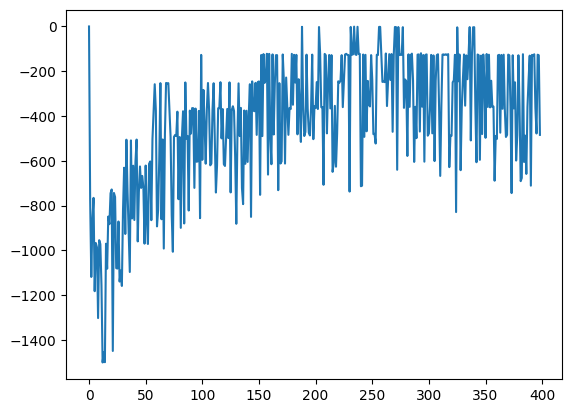

In [9]:
if __name__ == '__main__':
    #to save the model for testing
    log_name = '0404'
    model_save_dir = 'saved_model/' + log_name
    if not os.path.isdir(model_save_dir): os.mkdir(model_save_dir)
    log_save_dir = 'log/' + log_name
    if not os.path.isdir(log_save_dir): os.mkdir(log_save_dir)

    agent = DQNAgent()

    EPISODE = 398
    print_once = True
    score_list = [0]  # total rewards obtained in each episode

    for EP in range(EPISODE):
        state = env.reset()
        score, done = 0.0, False
        maxQ_action_count = 0
        data = 500.0
        while not done:
            action, real_action, count = agent.choose_action(torch.FloatTensor(state))

            state_prime, reward, done, _ = env.step([real_action])

            agent.memory.put((state, action, reward, state_prime, done))

            score += reward
            maxQ_action_count += count

            state = state_prime

            if agent.memory.size() > 1000:  # 1000 Once a tuple of [s, a, r, s'] accumulates, learning begins
                if print_once: print("Training started!")
                print_once = False
                agent.train_agent()

            if EP % 10 == 0:
               torch.save(agent.Q.state_dict(), model_save_dir + "/DQN_Q_EP"+str(EP)+".pt")

            if score > max(score_list):  # When updating the maximum value of the score list, save the model
                 torch.save(agent.Q.state_dict(), "save_model/1225/DQN_Q_EP" + str(EP) + ".pt")
                 torch.save(agent.Q.state_dict(), "save_model/DQN_Q_network.pt")
                 print("...Save model...")

        print("EP:{}, Avg_Score:{:.1f}, MaxQ_Action_Count:{}, Epsilon:{:.5f}".format(EP, score, maxQ_action_count, agent.epsilon))
        score_list.append(score)

        if agent.epsilon > agent.epsilon_min:
            agent.epsilon *= agent.epsilon_decay


    plt.plot(score_list)
    plt.show()


## **Testing**

In [10]:
from IPython.display import display
from IPython import display as ipythondispaly
import imageio

In [11]:
class DQNAgent:
    def __init__(self, wight_file_path):
        self.state_dim     = 3
        self.action_dim    = 9
        self.lr            = 0.002
        self.trained_model = wight_file_path

        self.Q        = QNetwork(self.state_dim, self.action_dim, self.lr)
        self.Q.load_state_dict(torch.load(self.trained_model))

    def choose_action(self, state):
        with torch.no_grad():
            action = float(torch.argmax(self.Q(state)).numpy())
            real_action = (action - 4) / 2
        return real_action

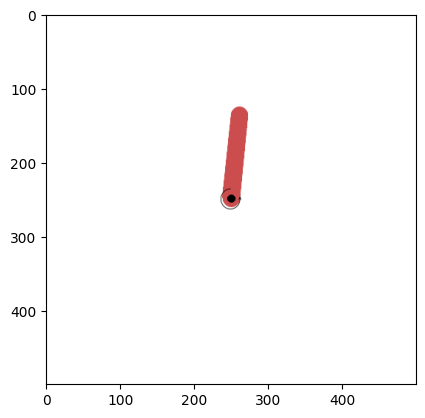

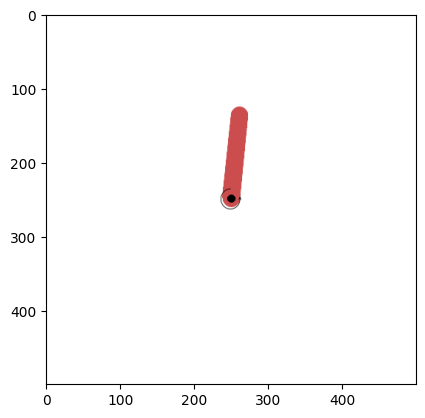

In [12]:
import pygame

env.reset()
pygame.init()
if __name__ == '__main__':

    log_name = '0404/'
    weight_name = 'DQN_Q_EP410.pt'

    weight_file_path = 'saved_model/' + log_name + weight_name
    agent = DQNAgent(weight_file_path)

    env = gym.make('Pendulum-v1')

    state = env.reset()
    step = 0

    for i in range(60):
        env.render()
        real_action = agent.choose_action(torch.FloatTensor(state))

        state_prime, reward, done, _ = env.step([real_action])
        screen=env.render(mode='rgb_array')
        step += 1

        state = state_prime
        plt.imshow(screen)
        ipythondispaly.clear_output(wait=True)
        display(plt.gcf())
        if step % 400 == 0:
            state = env.action_space.sample()


